In [1]:
import numpy as np
import george
from george import kernels
from scipy.optimize import minimize
from time import time
import argparse
import pickle
import matplotlib.pyplot as plt

In [2]:
def orig_to_trans(pars):
    gamma=pars[6]
    logM_env=pars[8]
    beta=pars[7]
    incl=pars[14]
    
    pars[6]=np.log10(2.1-1*gamma)
    pars[8]=np.log10(-1.5-1*logM_env)
    
    s=np.sin(0.7)
    c=np.cos(0.7)
    
    pars[7]=1-np.cos(((beta*c) + (incl*s/60)-.5)*np.pi/2)
    pars[14]=(-beta*s) + (incl*c/60)
    return pars

def trans_to_orig(pars):
    gamma_trans=pars[6]
    logM_env_trans=pars[8]
    bi_x=pars[7]
    bi_y=pars[14]
    
    pars[6]=2.1 - 10**gamma_trans
    pars[8]=-1.5 - 10**logM_env_trans
    
    s=np.sin(0.7)
    c=np.cos(0.7)
    
    pars[7]=round((1/(c+(s**2/c)))*((2/np.pi)*np.arccos(1-bi_x)+0.5-(s/c)*bi_y),14)
    pars[14]=round((60*s)*((2/np.pi)*np.arccos(1-bi_x)+0.5+(c/s)*bi_y),14)
    return pars

In [3]:
with open ('./gmd/cubefull.txt', 'rb') as fp:
    old_grid = np.array(pickle.load(fp))
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]
    
xvals=np.load("./etgrid/xvals.npy")
orig_dict=np.load("./gmd/dictionary.npy",allow_pickle=True)

def point(i):
    coo=[]
    for j in param_names:
        coo.append(orig_dict[i][j])
    transcoo=orig_to_trans(coo)
    sed = old_grid[i][100:500]
    return (transcoo, sed)

In [4]:
np.random.seed(seed=100)
sample=np.random.randint(0,3850,10)
sample_coords=[]
for i in range(len(sample)):
    sample_coords.append(point(sample[i])[0])

In [5]:
name = "cobyla"
inst = "3976"

conv=np.load("./etgrid/3976_nm_convergence.npy")
conv.shape

(2357, 16, 16)

In [6]:
coords=np.load("./etgrid/"+inst+"_coords.npy")
eigenseds=np.load("./etgrid/"+inst+"_eigenseds.npy")
weights=np.load("./etgrid/"+inst+"_weights.npy")
pcamean=np.load("./etgrid/"+inst+"_mean.npy")

yerrs=[]
for i in range(16):
    yerrs.append([x*0.05 for x in weights[i]])


In [7]:
kernel = 16*kernels.ExpSquaredKernel(15**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=5)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=14) 
blankhodlr=george.GP(kernel)

In [8]:
def pred(pred_coords,fit):
    gp=blankhodlr
    preds=[]
    if "cobyla" in name:
        hyperparams=np.transpose(np.array(fit).reshape(16,16))
    else:
        hyperparams=np.array(fit).reshape(16,16)

    for i in range(len(weights)):  # same covfunc for each weight and the sample mean
        gp.set_parameter_vector(hyperparams[i])
        gp.compute(coords,yerrs[i])
        pred, pred_var = gp.predict(weights[i], pred_coords, return_var=True)
        preds.append(pred)
    reconst_SEDs=[]
    for i in range(len(pred_coords)):
        reconst=np.dot(np.array(preds)[:,i][0:15],eigenseds[0:15]) + pcamean + np.array(preds)[:,i][15]
        reconst_SEDs.append(reconst)
    return reconst_SEDs, preds


In [9]:
t0=time()
predicted_SEDs_0, predicted_weights_0 =pred(sample_coords,conv[0])
predicted_SEDs_1000, predicted_weights_1000 =pred(sample_coords,conv[1000])
predicted_SEDs_2000, predicted_weights_2000 =pred(sample_coords,conv[2000])
predicted_SEDs_2250, predicted_weights_2250 =pred(sample_coords,conv[2250])
print(time()-t0)

802.7088947296143


1544
{'Tstar': 4199.56641046421, 'logL_star': 2.85281592655843, 'logM_disk': -2.9294592209991137, 'logR_disk': 2.6005302095205782, 'h_0': 0.48148388493241095, 'logR_in': 2.411200414040263, 'gamma': 1.3361703107586127, 'beta': 0.5449035498648207, 'logM_env': -2.7676289670969743, 'logR_env': 2.9978825572768706, 'f_cav': 0.15876738316292802, 'ksi': 0.9376541507186984, 'loga_max': 1.2044723013274434, 'p': 3.1420625184243183, 'incl': 23.91888271543316, 'filename': 'Tstar_4199.5_logLstar_2.853_logMdisk_-2.929_logRdisk_2.601_h0_0.481_logRin_2.411_gamma_1.336_beta_0.545_logMenv_-2.768_logRenv_2.998_fcav_0.159_ksi_0.938_logamax_1.204_p_3.142_incl_23.919.hdf5'}


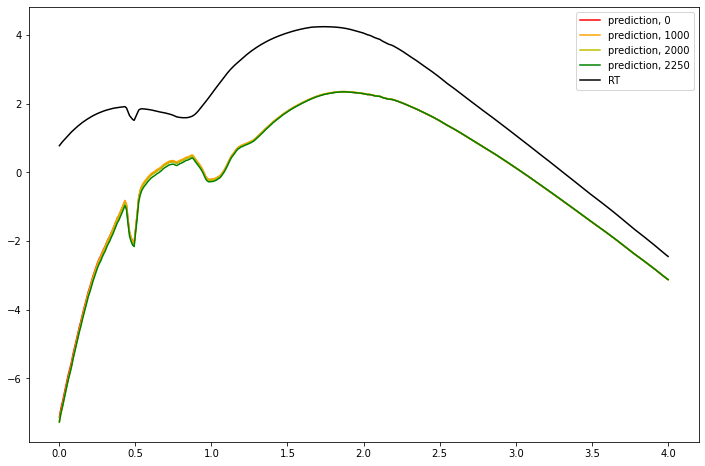

2840
{'Tstar': 4052.8048072165525, 'logL_star': -0.4742031739038671, 'logM_disk': -4.228589610120597, 'logR_disk': 1.763773247302657, 'h_0': 0.4796235759694844, 'logR_in': 1.6580309076501392, 'gamma': 1.203584753211446, 'beta': 0.9785615607933034, 'logM_env': -4.906667147230664, 'logR_env': 2.5668119746434144, 'f_cav': 0.1619997771792713, 'ksi': 1.173007176881626, 'loga_max': 4.564234372964447, 'p': 3.2608146680097074, 'incl': 33.85544274847727, 'filename': 'Tstar_4052.805_logLstar_-0.474_logMdisk_-4.229_logRdisk_1.764_h0_0.480_logRin_1.658_gamma_1.204_beta_0.979_logMenv_-4.907_logRenv_2.567_fcav_0.162_ksi_1.173_logamax_4.564_p_3.261_incl_33.855.hdf5'}


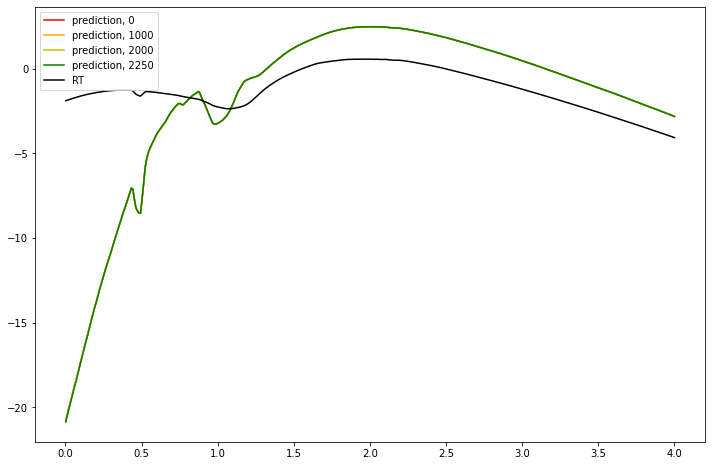

1859
{'Tstar': 4029.2376513363897, 'logL_star': 2.234230973874895, 'logM_disk': -2.3648041462095586, 'logR_disk': 2.699583931692943, 'h_0': 0.07521493457337713, 'logR_in': 1.142650412712904, 'gamma': 1.9482092047210953, 'beta': 1.7456961100349904, 'logM_env': -2.9409731107398613, 'logR_env': 3.0757015460936454, 'f_cav': 0.3434932407464302, 'ksi': 0.9698045873542, 'loga_max': 1.2965151229063323, 'p': 3.827831526941049, 'incl': 80.01807242539384, 'filename': 'Tstar_4029.238_logLstar_2.234_logMdisk_-2.365_logRdisk_2.700_h0_0.075_logRin_1.143_gamma_1.948_beta_1.746_logMenv_-2.941_logRenv_3.076_fcav_0.343_ksi_0.970_logamax_1.297_p_3.828_incl_80.018.hdf5'}


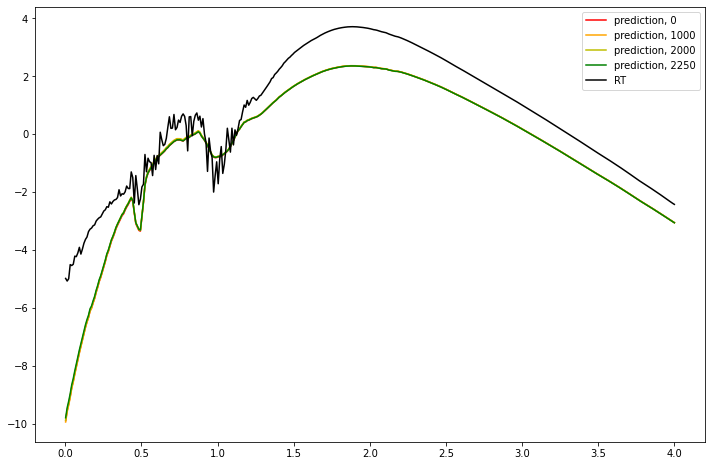

79
{'Tstar': 4779.74572740921, 'logL_star': 1.2035221606204258, 'logM_disk': -3.176570822055808, 'logR_disk': 2.344218226405769, 'h_0': 0.20338573167725715, 'logR_in': 1.376547975382309, 'gamma': 0.12764949232708775, 'beta': 0.6329341856580698, 'logM_env': -5.922527778667542, 'logR_env': 3.8783377965228665, 'f_cav': 0.326418004559722, 'ksi': 1.367718672239917, 'loga_max': 0.21121971203187148, 'p': 3.987688998186959, 'incl': 36.911080842343736, 'filename': 'Tstar_4779.746_logLstar_1.204_logMdisk_-3.177_logRdisk_2.344_h0_0.203_logRin_1.377_gamma_0.128_beta_0.633_logMenv_-5.923_logRenv_3.878_fcav_0.326_ksi_1.368_logamax_0.211_p_3.9_incl_36.911.hdf5'}


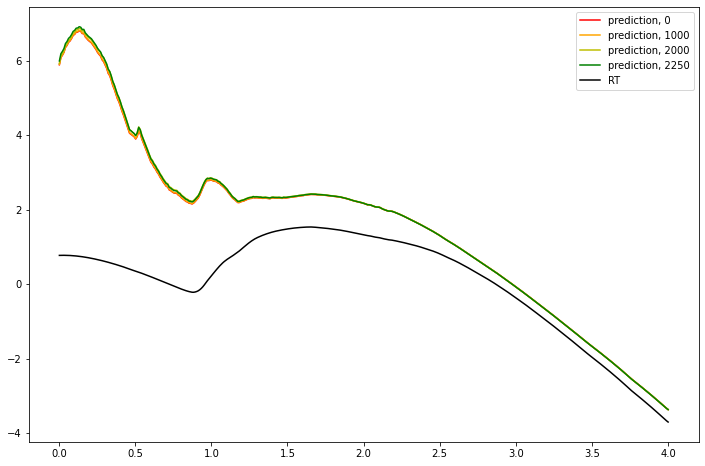

1930
{'Tstar': 3750.6160473368404, 'logL_star': 0.07063834883906495, 'logM_disk': -7.5256094372949045, 'logR_disk': 2.575600237037094, 'h_0': 0.22237062825324522, 'logR_in': -0.943368010970529, 'gamma': 1.2070509522541761, 'beta': 1.7727390001047882, 'logM_env': -4.191627232423801, 'logR_env': 3.6785470643910427, 'f_cav': 0.9256782959967308, 'ksi': 0.8061490007161071, 'loga_max': 3.300505788487768, 'p': 2.513688000125866, 'incl': 86.74634387553989, 'filename': 'Tstar_3750.616_logLstar_0.071_logMdisk_-7.526_logRdisk_2.576_h0_0.222_logRin_-0.943_gamma_1.207_beta_1.773_logMenv_-4.192_logRenv_3.679_fcav_0.926_ksi_0.806_logamax_3.301_p_2.514_incl_86.746.hdf5'}


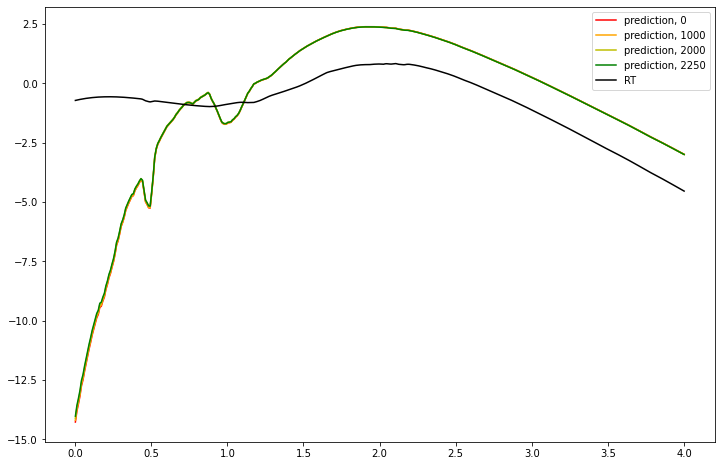

350
{'Tstar': 4767.9162266312815, 'logL_star': 0.98941933488109, 'logM_disk': -5.209147515709161, 'logR_disk': 2.5889612720562236, 'h_0': 0.18023293032267354, 'logR_in': -0.3719901200135831, 'gamma': 0.38517367151471615, 'beta': 1.7146132811352919, 'logM_env': -4.842130098684873, 'logR_env': 2.6247494648054075, 'f_cav': 0.38113405160896063, 'ksi': 1.229983366379741, 'loga_max': 4.306013096365408, 'p': 2.8014082125781403, 'incl': 74.59087167996526, 'filename': 'Tstar_4767.916_logLstar_0.989_logMdisk_-5.209_logRdisk_2.589_h0_0.180_logRin_-0.372_gamma_0.385_beta_1.715_logMenv_-4.842_logRenv_2.625_fcav_0.381_ksi_1.230_logamax_4.306_p_2.801_incl_74.591.hdf5'}


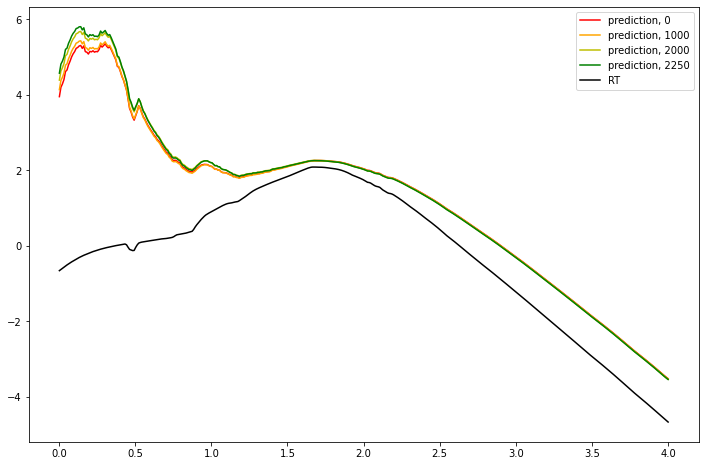

1972
{'Tstar': 4486.27245534445, 'logL_star': -0.07074306334691838, 'logM_disk': -7.2269343082776665, 'logR_disk': 1.5863746026615297, 'h_0': 0.20078018232873113, 'logR_in': -0.7346116517686951, 'gamma': 0.6004589191622374, 'beta': 1.739519762423241, 'logM_env': -4.623097297733166, 'logR_env': 2.7843395053046924, 'f_cav': 0.2154624996366238, 'ksi': 0.7577638228791266, 'loga_max': 2.872259880276085, 'p': 4.441168738109081, 'incl': 79.23681640816815, 'filename': 'Tstar_4486.272_logLstar_-0.071_logMdisk_-7.227_logRdisk_1.586_h0_0.201_logRin_-0.735_gamma_0.600_beta_1.740_logMenv_-4.623_logRenv_2.784_fcav_0.215_ksi_0.758_logamax_2.872_p_4.441_incl_79.237.hdf5'}


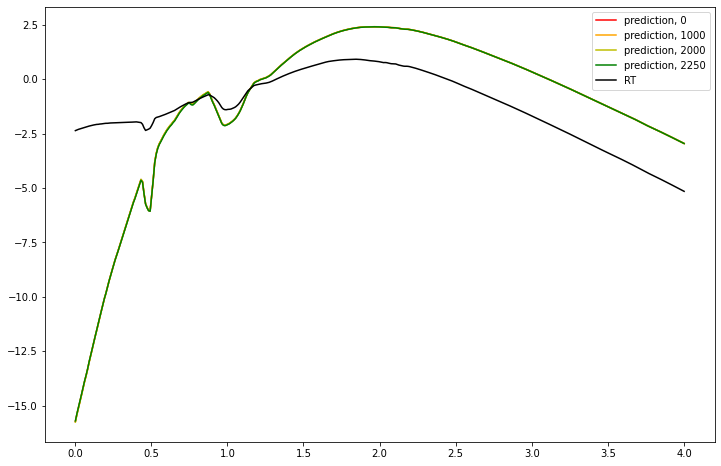

1890
{'Tstar': 3014.245589912348, 'logL_star': 0.19473622476599206, 'logM_disk': -6.528221935797542, 'logR_disk': 1.1101747893507599, 'h_0': 0.05132665915870634, 'logR_in': -0.18002863590521956, 'gamma': 1.7492165201811851, 'beta': 1.5025966390137941, 'logM_env': -3.333353515842207, 'logR_env': 3.7807698934758887, 'f_cav': 0.24447950021963266, 'ksi': 1.2783679681070688, 'loga_max': 2.9430891628238296, 'p': 4.104814333046452, 'incl': 55.61527716718773, 'filename': 'Tstar_3014.246_logLstar_0.195_logMdisk_-6.528_logRdisk_1.110_h0_0.051_logRin_-0.180_gamma_1.749_beta_1.503_logMenv_-3.333_logRenv_3.781_fcav_0.244_ksi_1.278_logamax_2.943_p_4.105_incl_55.615.hdf5'}


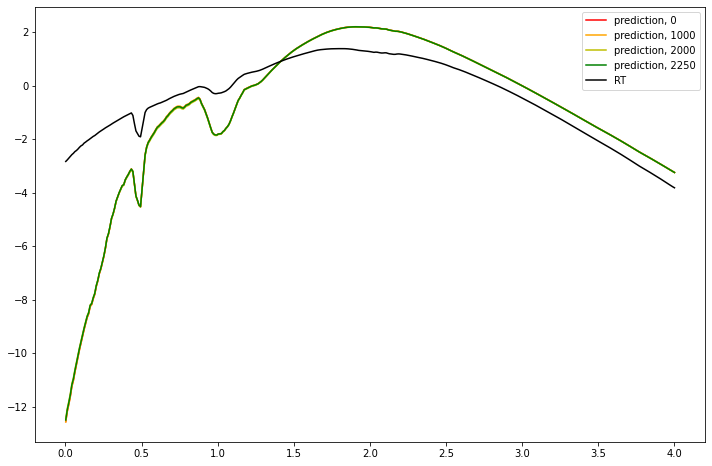

53
{'Tstar': 4614.3676229251905, 'logL_star': 0.8522860093606823, 'logM_disk': -6.067903024133363, 'logR_disk': 2.3798801956962174, 'h_0': 0.14232506886024587, 'logR_in': 0.3725567885975196, 'gamma': 0.2777084739979055, 'beta': 1.9957573860222213, 'logM_env': -5.679639861665991, 'logR_env': 2.504689235772373, 'f_cav': 0.0391751755772318, 'ksi': 0.9250726349031282, 'loga_max': 4.430782703253755, 'p': 4.142100270901226, 'incl': 11.956077733891332, 'filename': 'Tstar_4614.368_logLstar_0.852_logMdisk_-6.068_logRdisk_2.380_h0_0.142_logRin_0.373_gamma_0.278_beta_1.996_logMenv_-5.680_logRenv_2.505_fcav_0.039_ksi_0.925_logamax_4.431_p_4.142_incl_11.956.hdf5'}


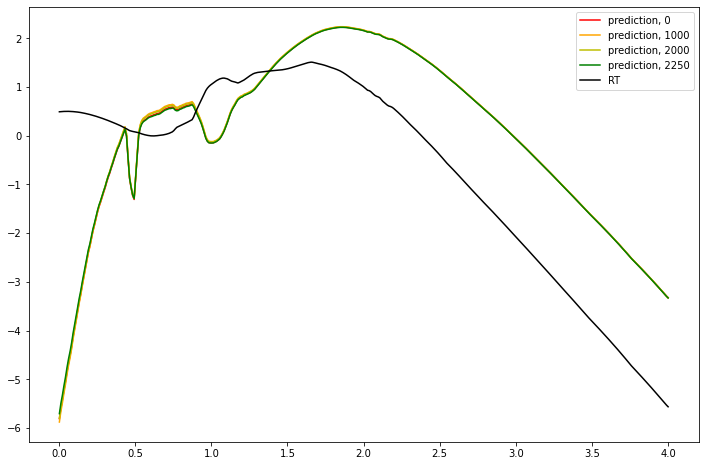

1602
{'Tstar': 3092.5484065445894, 'logL_star': -0.018425403870834134, 'logM_disk': -4.5623764496983785, 'logR_disk': 2.0316919098019444, 'h_0': 0.07926248847728218, 'logR_in': 0.8695641205449665, 'gamma': 0.28977102841681684, 'beta': 1.2841334537640468, 'logM_env': -2.010838409583676, 'logR_env': 3.511483355878613, 'f_cav': 0.9307793402236059, 'ksi': 1.148219269522774, 'loga_max': 4.2726604501895125, 'p': 3.6938858582942995, 'incl': 86.10711198226981, 'filename': 'Tstar_3092.548_logLstar_-0.018_logMdisk_-4.562_logRdisk_2.032_h0_0.079_logRin_0.870_gamma_0.290_beta_1.284_logMenv_-2.011_logRenv_3.511_fcav_0.931_ksi_1.148_logamax_4.273_p_3.694_incl_86.107.hdf5'}


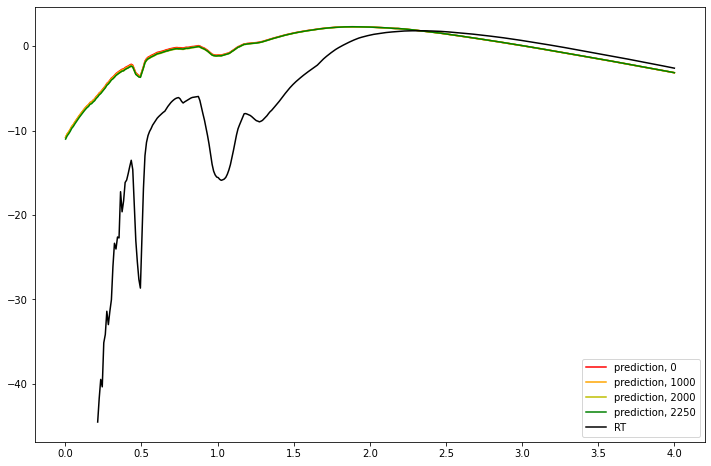

In [10]:
for i in range(len(predicted_SEDs_0)):
    print(sample[i])
    print(orig_dict[sample[i]])
    plt.figure(figsize=(12,8))
    plt.plot(np.log10(xvals),predicted_SEDs_0[i],c='r',label="prediction, 0")
    plt.plot(np.log10(xvals),predicted_SEDs_1000[i],c='orange',label="prediction, 1000")
    plt.plot(np.log10(xvals),predicted_SEDs_2000[i],c='y',label="prediction, 2000")
    plt.plot(np.log10(xvals),predicted_SEDs_2250[i],c='g',label="prediction, 2250")
    #plt.plot(np.log10(xvals),predicted_SEDs_1000[i],c='b',label="prediction, 1000")
    #plt.plot(np.log10(xvals),predicted_SEDs_1250[i],c='violet',label="prediction, 1250")
    #plt.plot(np.log10(xvals),predicted_SEDs_1473[i],c='fuchsia',label="prediction, 1473")
    plt.plot(np.log10(xvals),point(sample[i])[1],c='k',label="RT")
    plt.legend()
    plt.show()